In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers

     |████████████████████████████████| 1.8MB 7.6MB/s 
     |████████████████████████████████| 890kB 31.4MB/s 
     |████████████████████████████████| 2.9MB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fb84e0eef4f0eef889431ce4e50b483af2b21f1f7413ad80d7c195295b176296
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import Parameter
from transformers import BertModel
from transformers import BertConfig
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.optim as optim

In [ ]:
import pickle

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_df(file):
    return pd.read_csv(file,sep = '\t')

In [ ]:
train_df = get_df('/content/drive/My Drive/fake_news_dataset/mediaeval2016/train_posts.txt')
test_df = get_df('/content/drive/My Drive/fake_news_dataset/mediaeval2016/test_posts.txt')

In [ ]:
train_df

,post_id,post_text,user_id,image_id(s),username,timestamp,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake
...,...,...,...,...,...,...,...
15624,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake
15625,578433646597656576,"Oh les kleine menteurs \""@CorineBarella: Un pr...",27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake
15626,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake
15627,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake


## Image Embedding processing

In [ ]:
y_train = train_df['label'].eq('real').astype(int)
y_test = test_df['label'].eq('real').astype(int)

In [ ]:
train_img = train_df['image_id(s)']
test_img = test_df['image_id']

In [ ]:
print(len(train_img.unique()))
print(len(test_img.unique()))

441
130


In [ ]:
from os import walk
mypath = "/content/drive/My Drive/fake_news_dataset/mediaeval2016/images_test/"
test_img_data = []
for (dirpath, dirnames, filenames) in walk(mypath):
    test_img_data.extend(filenames)
    break

In [ ]:
from os import walk
mypath = "/content/drive/My Drive/fake_news_dataset/mediaeval2016/images_train/"
train_img_data = []
for (dirpath, dirnames, filenames) in walk(mypath):
    train_img_data.extend(filenames)
    break

In [ ]:
from os import walk
mypath = "/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_train/"
pickle_img_data = []
for (dirpath, dirnames, filenames) in walk(mypath):
    pickle_img_data.extend(filenames)
    break

In [ ]:
from os import walk
mypath = "/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_test/"
pickle_img_test = []
for (dirpath, dirnames, filenames) in walk(mypath):
    pickle_img_test.extend(filenames)
    break

In [ ]:
print(len(train_img_data))
print(len(pickle_img_data))
print(len(test_img_data))
print(len(pickle_img_test))

410
408
104
104


In [ ]:
pickle_img_fin = [img[:-4] for img in pickle_img_data]

In [ ]:
pkl_img_fin_test = [img[:-4] for img in pickle_img_test]

print(len(pkl_img_fin_test))

104


In [ ]:
dict_feat = {}

for file_name in pickle_img_data :
  dict_feat[file_name[:-4]] =  pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_train/"+file_name,"rb"))

In [ ]:
c=0
shape_not_match = []
for key in dict_feat :
  if(dict_feat[key].shape[0]!=36) :
    shape_not_match.append(key)
    c+=1
print(c)
print(len(shape_not_match))

43
43


In [ ]:
dict_feat

{'boston_fake_01': tensor([[0.0000, 0.0000, 0.1114,  ..., 0.0000, 0.0000, 0.1616],
         [0.3131, 0.0000, 0.0953,  ..., 1.7216, 4.9124, 0.1339],
         [0.0051, 0.0143, 0.1978,  ..., 0.0000, 0.0777, 0.0242],
         ...,
         [0.0000, 0.0906, 0.0000,  ..., 0.0000, 0.8309, 1.2299],
         [0.0000, 0.2076, 0.0000,  ..., 0.0000, 1.5466, 1.0192],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0165, 0.0000]],
        device='cuda:0'),
 'boston_fake_02': tensor([[7.3643e-01, 0.0000e+00, 0.0000e+00,  ..., 5.8619e-01, 3.4072e+00,
          1.1376e+00],
         [2.9675e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.4900e-01,
          8.7860e-03],
         [2.9675e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.4900e-01,
          8.7860e-03],
         ...,
         [0.0000e+00, 4.0595e+00, 0.0000e+00,  ..., 0.0000e+00, 6.4569e+00,
          2.6250e-01],
         [0.0000e+00, 1.9439e-01, 0.0000e+00,  ..., 2.9255e+00, 1.0126e+01,
          0.0000e+00],
         [0.0000e+00, 5.

In [ ]:
fin_train_img = []
c=0
ids_train = []
for i in range(len(train_img)) :
  img = train_img[i]
  main_image = ""
  if(',' in img) :
    main_images = img.split(',')
    for img in main_images :
      if (img in pickle_img_fin) :
        main_image = img
        break 
  else :
    main_image = img

  if((main_image in pickle_img_fin) and (main_image not in shape_not_match)) :
    fin_train_img.append(main_image)
    ids_train.append(i)
    c+=1

print(c)
print(len(ids_train))
print(len(fin_train_img))

11789
11789
11789


In [ ]:
dict_feat_test = {}

for file_name in pickle_img_test :
  dict_feat_test[file_name[:-4]] =  pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_test/"+file_name,"rb"))

In [ ]:
c=0
shape_not_match_test = []
for key in dict_feat_test :
  if(dict_feat_test[key].shape[0]!=36) :
    shape_not_match_test.append(key)
    c+=1
print(c)
print(len(shape_not_match_test))

9
9


In [ ]:
fin_test_img = []
c=0
ids_test = []
for i in range(len(test_img)) :
  img = test_img[i]
  main_image = ""
  if(',' in img) :
    main_images = img.split(',')
    for img in main_images :
      if (img in pkl_img_fin_test) :
        main_image = img
        break 
  else :
    main_image = img

  if((main_image in pkl_img_fin_test) and (main_image not in shape_not_match_test)) :
    fin_test_img.append(main_image)
    ids_test.append(i)
    c+=1

print(c)
print(len(ids_test))
print(len(fin_test_img))

794
794
794


In [ ]:
train_input_img = torch.zeros((11789,36,2048))
train_output_img = torch.zeros((11789,1))

for i in range(len(fin_train_img)) :
  main_image = fin_train_img[i]
  index = ids_train[i]
  if (main_image not in dict_feat) :
      ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_train/"+main_image+".pkl","rb"))
      dict_feat[main_image] = ar
  else :
    ar = dict_feat[main_image]
  train_input_img[i] = ar
  train_output_img[i] = y_train[index]


# for i in range(len(train_img)) :
#   img = train_img[i]
#   main_image = ""
#   if(',' in img) :
#     main_images = img.split(',')
#     for img in main_images :
#       if((img in train_img_data) :
#         main_image = img
#         break 
#   else :
#     main_image = img
#   if(main_image in train_img_data)
#     if (main_image not in dict_feat) :
#       ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_train/"+main_image+".pkl","rb"))
#       dict_feat[main_image] = ar
#     else :
#       ar = dict_feat[main_image]
#     train_input_img[count] = ar
#     train_output_img[count] = y_train[i]
#     ids_train.append(i)
#     count+=1
#   except :
#     tr_img_not_found.append(main_image)
#     continue

In [ ]:
len(ids_train)

11789

In [ ]:
test_input_img = torch.zeros((794,36,2048))
test_output_img = torch.zeros((794,1))

for i in range(len(fin_test_img)) :
  main_image = fin_test_img[i]
  index = ids_test[i]
  test_input_img[i] = dict_feat_test[main_image]
  test_output_img[i] = y_test[index]

# for i in range(len(test_img)) :
#   img = test_img[i]
#   main_image = ""
#   if(',' in img) :
#     main_image = img.split(',')[0]
#   else :
#     main_image = img
#   try: 
#     if (main_image not in dict_feat_test) :
#       ar = pickle.load(open("/content/drive/My Drive/multi-modal/mediaeval/airsplay/feat_test/"+main_image+".pkl","rb"))
#       dict_feat_test[main_image] = ar
#     else :
#       ar = dict_feat_test[main_image]
#     test_input_img[count] = ar
#     test_output_img[count] = y_test[i] 
#     ids_test.append[i]
#     count+=1 
#   except :
#     ts_img_not_found.append(main_image)
#     continue

In [ ]:
print(len(train_input_img))
print(len(train_output_img))

11789
11789


In [ ]:
def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class BERTLayerNorm(nn.Module):
    def __init__(self, config, variance_epsilon=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(BERTLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(config.hidden_size))
        self.beta = nn.Parameter(torch.zeros(config.hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class BERTSelfAttention(nn.Module):
    def __init__(self, config):
        super(BERTSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer


class BERTSelfOutput(nn.Module):
    def __init__(self, config):
        super(BERTSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BERTAttention(nn.Module):
    def __init__(self, config):
        super(BERTAttention, self).__init__()
        self.self = BERTSelfAttention(config)
        self.output = BERTSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output


class BERTIntermediate(nn.Module):
    def __init__(self, config):
        super(BERTIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BERTOutput(nn.Module):
    def __init__(self, config):
        super(BERTOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BERTLayer(nn.Module):
    def __init__(self, config):
        super(BERTLayer, self).__init__()
        self.attention = BERTAttention(config)
        self.intermediate = BERTIntermediate(config)
        self.output = BERTOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

In [ ]:
class TransformerMapping(nn.Module):
    """ Self-attention layer for image branch
    """
    def __init__(self):
        super(TransformerMapping, self).__init__()
        bert_config = BertConfig.from_json_file("t_cfg.json")
        self.layer = BERTLayer(bert_config)
        self.mapping = nn.Linear(2048, 256)
        #self.mapping2 = nn.Linear(opt.final_dims, opt.final_dims)

    def forward(self, x):
        # x: (batch_size, patch_num, img_dim)
        # print("x", x.shape)
        x = self.mapping(x) # x: (batch_size, patch_num, final_dims)
        # print("x_mapping", x.shape)
        attention_mask = torch.ones(x.size(0), x.size(1))
        if torch.cuda.is_available():
            attention_mask = attention_mask.cuda()
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.float()
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        hidden_states = self.layer(x, extended_attention_mask)
        # print("hidden_states",hidden_states.shape)
        # hidden_states = self.mapping2(hidden_states)
        embed = torch.mean(hidden_states, 1) # (batch_size, final_dims)
        codes = F.normalize(embed, p=2, dim=1)  # (N, C)
        return codes

## Text embedding processing

In [ ]:
x_train = train_df['post_text']
x_test = test_df['post_text']

In [ ]:
ids_train

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 113,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 19

In [ ]:
x_train_text = []
x_test_text = []

for ind in ids_train :
  x_train_text.append(x_train[ind])

for ind in ids_test :
  x_test_text.append(x_test[ind])

In [ ]:
print(len(x_train_text))
print(len(x_test_text))

11789
794


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def get_token_ids(x_train, x_test):
    
    token_tr = []
    token_tst = []
    count = 0
    for sent in x_train :
        tokens = tokenizer.encode(sent, add_special_tokens = True, max_length=512)
        token_tr.append(tokens)
        count+=1
        if(count%1000==0):
            print(count)
    
    for sent1 in x_test :
        tokens1 = tokenizer.encode(sent1, add_special_tokens = True, max_length=512)
        token_tst.append(tokens1)
        count+=1
        if(count%1000==0):
            print(count)
            
    return token_tr, token_tst 

In [ ]:
xtr_token, xtst_token = get_token_ids(x_train_text, x_test_text)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [ ]:
xtr_token = pad_sequences(xtr_token, maxlen=512, dtype="long", 
                          value=0, truncating="post", padding="post")
xtst_token = pad_sequences(xtst_token, maxlen=512, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
attention_mask_tr = []
attention_mask_tst = []
for sent in xtr_token:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_mask_tr.append(att_mask)

for sent in xtst_token:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_mask_tst.append(att_mask)

In [ ]:
train_input_text = torch.tensor(xtr_token)
test_input_text = torch.tensor(xtst_token)

train_mask = torch.tensor(attention_mask_tr)
test_mask = torch.tensor(attention_mask_tst)

In [ ]:
def freeze_layers(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
class BertMapping(nn.Module):
    """
    """
    def __init__(self):
        super(BertMapping, self).__init__()
        bert_config = BertConfig.from_pretrained('bert-base-uncased')
        self.bert = BertModel(bert_config)
        freeze_layers(self.bert)
        final_dims = 256
        Ks = [1, 2, 3]
        in_channel = 1
        out_channel = 512
        embedding_dim = bert_config.hidden_size
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channel, out_channel, (K, embedding_dim)) for K in Ks])
        self.dropout = nn.Dropout(bert_config.hidden_dropout_prob)
        self.mapping = nn.Linear(len(Ks)*out_channel, final_dims)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids,attention_mask=attention_mask, return_dict=True)
        x = outputs.last_hidden_state.unsqueeze(1)  # (batch_size, 1, token_num, embedding_dim)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(batch_size, out_channel, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        output = torch.cat(x, 1)
        output = self.dropout(output)
        code = self.mapping(output)
        # code = F.tanh(code)
        code = F.normalize(code, p=2, dim=1)
        return code

## Final model

In [ ]:
class FinalModel(nn.Module) :
  """
  """
  def __init__(self):
    super(FinalModel, self).__init__()
    self.text_enc_model = BertMapping()
    self.img_enc_model = TransformerMapping()
    img_dims = 256
    text_dims = 256
    self.cls_layer = nn.Linear(img_dims+text_dims,1)

  def forward(self, input_ids, attention_mask, img) :
    img_enc = self.img_enc_model(img)
    text_enc = self.text_enc_model(input_ids, attention_mask)
    final_enc = torch.cat((img_enc, text_enc), 1)
    # print(final_enc.shape)
    code = self.cls_layer(final_enc)
    return code

## Training code

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64

train_data = TensorDataset(train_input_text, train_mask, train_input_img, train_output_img)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
# Create the DataLoader for our validation set.
test_data = TensorDataset(test_input_text, test_mask, test_input_img, test_output_img)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def get_labels_from_logits(logits) :
  probs = torch.sigmoid(logits.unsqueeze(-1))
  soft_probs = (probs > 0.5).long()
  labels = soft_probs.squeeze()
  return labels

In [ ]:
from sklearn.metrics import classification_report
def eval_model(model, val_loader, criterion) :
  model.eval()
  final_out = []
  final_lab = []

  loss_val = 0
  for idx, (val_input, val_mask, val_img, val_label) in enumerate(val_loader):
    # try:
      val_input = val_input.cuda()
      val_mask = val_mask.cuda()
      val_img = val_img.cuda()
      val_label = val_label.cuda()
      output = model(val_input, val_mask, val_img)
      loss = criterion(output.squeeze(-1), val_label.float().squeeze(-1))
      loss_val+= loss.data
      output = get_labels_from_logits(output)
      output = output.cpu().detach().numpy()
      val_label = val_label.cpu().detach().numpy()
      # print(output.shape)
      # print(val_label.shape)
      final_out.extend(list(output))
      final_lab.extend(list(val_label))

      del val_input
      del val_label
      del output
      torch.cuda.empty_cache()
    # except:
    #   print("error") 

        
  return classification_report(final_lab, final_out), loss_val

In [ ]:
def train(net, criterion, opti, train_loader, num_epochs, val_loader):
  loss_train = []
  loss_test = []
  for epoch in range(num_epochs):
    loss_val = 0
    for it, (text, mask,img, labels) in enumerate(train_loader):
        #Clear gradients
        opti.zero_grad()  
        #Converting these to cuda tensors
        text, mask, img, labels = text.cuda(), mask.cuda(), img.cuda(), labels.cuda()

        #Obtaining the logits from the model
        logits = net(text, mask, img)

        #Computing loss
        loss = criterion(logits.squeeze(-1), labels.float().squeeze(-1))
        loss_val += loss.data

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if (it + 1) % 20 == 0:
            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. Loss : {} Accuracy : {}".format(it+1, epoch+1, loss.item(), acc))

        del text
        del mask
        del img
        del labels
        del logits
        del loss
        torch.cuda.empty_cache()

    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss_val))
    loss_train.append(loss_val)
    if((epoch+1)%1==0) :
      report, loss_t = eval_model(net, val_loader, criterion)
      loss_test.append(loss_t)
      print("loss_test", loss_t)
      print("classification_report")
      print(report)
    print("--------------------------------------------------------------")
  return loss_train, loss_test

In [ ]:
net = FinalModel().to(device)
criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(net.parameters(), lr = 1e-3)
loss_train, loss_test = train(net, criterion, opti, train_dataloader, 30, test_dataloader)

Iteration 20 of epoch 1 complete. Loss : 0.5125252604484558 Accuracy : 0.505859375
Iteration 40 of epoch 1 complete. Loss : 0.42075228691101074 Accuracy : 0.5087890625
Iteration 60 of epoch 1 complete. Loss : 0.3448556661605835 Accuracy : 0.5146484375
Iteration 80 of epoch 1 complete. Loss : 0.31319254636764526 Accuracy : 0.52392578125
Iteration 100 of epoch 1 complete. Loss : 0.27623051404953003 Accuracy : 0.5
Iteration 120 of epoch 1 complete. Loss : 0.21956408023834229 Accuracy : 0.50390625
Iteration 140 of epoch 1 complete. Loss : 0.2220228612422943 Accuracy : 0.51953125
Iteration 160 of epoch 1 complete. Loss : 0.19185438752174377 Accuracy : 0.513671875
Iteration 180 of epoch 1 complete. Loss : 0.2855950593948364 Accuracy : 0.49560546875
Epoch [1/30], Loss:61.7624
loss_test tensor(11.3203, device='cuda:0')
classification_report
              precision    recall  f1-score   support

         0.0       0.67      0.39      0.49       384
         1.0       0.59      0.81      0.68   

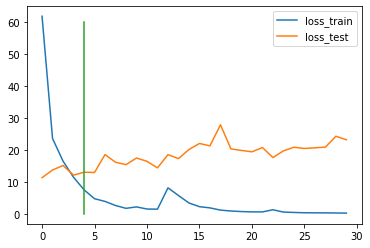

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_train, label="loss_train")
plt.plot(loss_test, label="loss_test")
plt.plot([4,4], [0, 60])
plt.legend()
plt.show()

In [ ]:
eval_model(net, test_dataloader)

(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(64,)
(64, 1)
(26,)
(26, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n         0.0       0.48      1.00      0.65       384\n         1.0       0.00      0.00      0.00       410\n\n    accuracy                           0.48       794\n   macro avg       0.24      0.50      0.33       794\nweighted avg       0.23      0.48      0.32       794\n'

In [ ]:
net.eval()

FinalModel(
  (text_enc_model): BertMapping(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
print(eval_model(net, test_dataloader))

              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72       384
         1.0       0.76      0.62      0.68       410

    accuracy                           0.70       794
   macro avg       0.71      0.70      0.70       794
weighted avg       0.71      0.70      0.70       794

